In [1]:
import matplotlib.pyplot as plt

In [54]:
log = open("./log-edu.txt", "r")
train_loss_list = []
val_loss_list = []
norm_list = []
lr_list = []
for i in log:
    data = i.split("|")
    train_loss_list.append(data[1])
    val_loss_list.append(data[2])
    norm_list.append(data[3])
    lr_list.append(data[4])

train_loss = []
val_loss = []
norm = []
lr = []

for i in train_loss_list:
    x = i.split(":")[1]
    x = x.replace(" ", "")
    train_loss.append(float(x))

for i in val_loss_list:
    x = i.split(":")[1]
    x = x.replace(" ", "")
    val_loss.append(float(x))

for i in norm_list:
    x = i.split(":")[1]
    x = x.replace(" ", "")
    norm.append(float(x))

for i in lr_list:
    x = i.split(":")[1]
    x = x.replace(" ", "")
    lr.append(float(x))

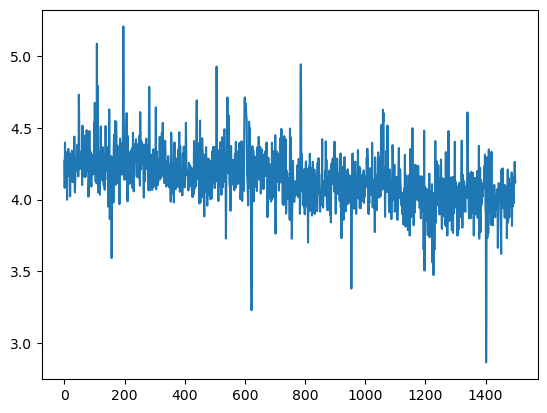

In [55]:
plt.plot(train_loss)

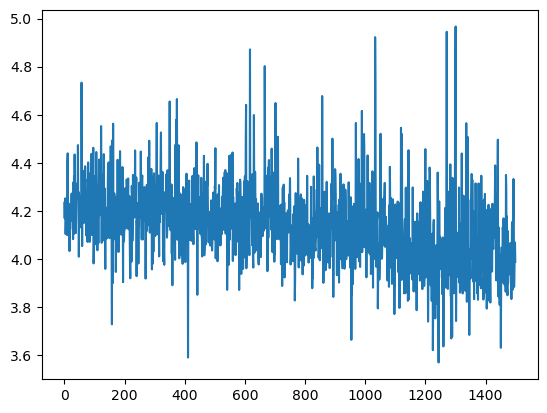

In [56]:
plt.plot(val_loss)

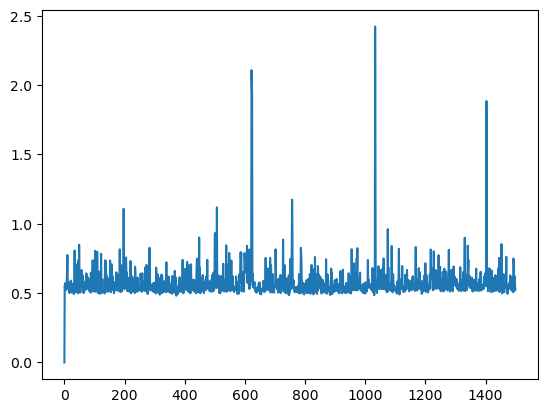

In [57]:
plt.plot(norm)

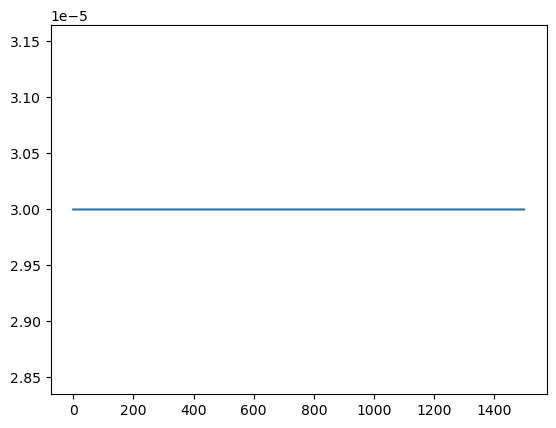

In [58]:
plt.plot(lr)

In [70]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
class CausalSelfAttention(nn.Module):

    def __init__(self, n_embed, n_head):
        self.n_embd = n_embed
        self.n_head = n_head
        super().__init__()
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(self.n_embd, 3 * self.n_embd)
        # output projection
        self.c_proj = nn.Linear(self.n_embd, self.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):
    def __init__(self, embed_dim):
        super(MLP, self).__init__()
        
        self.MLP = nn.Sequential(
            nn.Linear(embed_dim, 4 *  embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim), 
        )
        self.scale_init = 1
    def forward(self, x):
        return self.MLP(x)

class Block(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super(Block, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.LayerNorm1 = nn.LayerNorm(embed_dim) 
        self.MultiheadAttention = CausalSelfAttention(self.embed_dim, self.num_heads)
        self.LayerNorm2 = nn.LayerNorm(embed_dim)
        self.MLP = MLP(embed_dim)
        
    def forward(self, x):
        x = x + self.MultiheadAttention(self.LayerNorm1(x))
        x = x + self.MLP(self.LayerNorm2(x))
        return x

class Model1(nn.Module):
    def __init__(self, block_size, vocab_size, embed_dim, num_heads, num_blocks, dropout):
        super(Model1, self).__init__()
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim  
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.dropout = dropout

        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        self.positional_embedding = nn.Embedding(self.block_size, self.embed_dim)

        self.blocks = nn.ModuleList([Block(self.embed_dim, self.num_heads, self.dropout) for _ in range(self.num_blocks)])

        self.LayerNorm3 = nn.LayerNorm(self.embed_dim)
        self.lm_linear = nn.Linear(self.embed_dim, self.vocab_size)
        
        #weight sharing scheme
        self.lm_linear.weight = self.embedding.weight

        # Apply parameter initialization as per GPT2 model
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if hasattr(module, "NANOGPT_SCALE_INIT"):
            std *= (2 * self.num_blocks) ** -0.5
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)

        for pn, p in self.named_parameters():
            print(f"{pn=}")        
            print(f"{p=}")
        
    def forward(self, x):
        B, T = x.shape
        x = self.embedding(x)
        x = x + self.positional_embedding(torch.arange(T, device=device))
        for block in self.blocks:
            x = block(x)
        output = self.LayerNorm3(x)
        output = self.lm_linear(output)
        return output

In [71]:
vocab_size = 50304 
block_size = 2048
batch_size = 4 
device = "mps"

model = Model1(block_size=block_size, vocab_size=vocab_size, embed_dim=1024, num_heads=16, num_blocks=8, dropout=0.2).to(device)

pn='embedding.weight'
p=Parameter containing:
tensor([[-0.0004,  0.0248, -0.0332,  ..., -0.0224, -0.0132, -0.0120],
        [-0.0398, -0.0089,  0.0048,  ...,  0.0381,  0.0102, -0.0156],
        [-0.0225,  0.0102,  0.0007,  ..., -0.0233, -0.0387, -0.0022],
        ...,
        [ 0.0086,  0.0015, -0.0103,  ..., -0.0127, -0.0203, -0.0024],
        [-0.0390, -0.0056,  0.0344,  ..., -0.0169,  0.0212,  0.0377],
        [ 0.0374, -0.0044, -0.0186,  ...,  0.0057,  0.0130, -0.0102]],
       requires_grad=True)
pn='positional_embedding.weight'
p=Parameter containing:
tensor([[-1.7996,  0.4056, -0.3603,  ..., -0.1176, -0.0853, -1.2004],
        [-2.3562,  1.3322,  0.4245,  ...,  1.1111,  0.1710,  0.0472],
        [-0.0683,  0.4869, -0.6299,  ..., -1.1739, -1.4428,  0.5852],
        ...,
        [ 0.3913, -0.1033, -0.5159,  ..., -1.3066,  0.8295, -1.6806],
        [-0.0889, -0.0455, -2.0056,  ...,  0.1859, -0.6180,  0.5646],
        [-0.1941,  0.7559, -2.2823,  ..., -1.2946, -1.0974, -0.5883]],
  

In [63]:
for i in model.parameters():
    print(i)
    break

Parameter containing:
tensor([[ 0.0233, -0.0098,  0.0083,  ...,  0.0012, -0.0085,  0.0162],
        [-0.0065,  0.0057, -0.0044,  ...,  0.0196, -0.0193,  0.0081],
        [-0.0028,  0.0045,  0.0129,  ...,  0.0197, -0.0049,  0.0122],
        ...,
        [-0.0098, -0.0319, -0.0006,  ...,  0.0243,  0.0197,  0.0014],
        [-0.0174,  0.0069, -0.0192,  ...,  0.0074, -0.0357,  0.0383],
        [ 0.0093, -0.0023,  0.0202,  ..., -0.0142,  0.0134,  0.0128]],
       device='mps:0', requires_grad=True)


In [19]:
import tiktoken

vocab_size = 50304 
block_size = 2048
batch_size = 4 
device = "mps"

enc = tiktoken.encoding_for_model("gpt2")
eot = enc._special_tokens['<|endoftext|>'] 
model = Model1(block_size=block_size, vocab_size=vocab_size, embed_dim=1024, num_heads=16, num_blocks=8, dropout=0.2).to(device)
model.eval()

Model1(
  (embedding): Embedding(50304, 1024)
  (positional_embedding): Embedding(2048, 1024)
  (blocks): ModuleList(
    (0-7): 8 x Block(
      (LayerNorm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (MultiheadAttention): CausalSelfAttention(
        (c_attn): Linear(in_features=1024, out_features=3072, bias=True)
        (c_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (LayerNorm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (MLP): MLP(
        (MLP): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
  )
  (LayerNorm3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (lm_linear): Linear(in_features=1024, out_features=50304, bias=True)
)

In [45]:
model.eval()
num_return_sequences = 4
max_length = 32
tokens = enc.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)
while xgen.size(1) < max_length:
    with torch.no_grad():
        logits = model(xgen) # (B, T, vocab_size)
        logits = logits[:, -1, :] # (B, vocab_size)
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
                # select a token from the top-k probabilities
                # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
                # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
                # append to the sequence
        xgen = torch.cat((xgen, xcol), dim=1)
    
    for i in range(num_return_sequences):
            tokens = xgen[i, :max_length].tolist()
            decoded = enc.decode(tokens)
            print(f"sample {i}: {decoded}")


sample 0: Hello, I'm a language model, JD
sample 1: Hello, I'm a language model, Pebble
sample 2: Hello, I'm a language model, podcast
sample 3: Hello, I'm a language model,DE
sample 0: Hello, I'm a language model, JDbed
sample 1: Hello, I'm a language model, Pebble theoret
sample 2: Hello, I'm a language model, podcast Egyptian
sample 3: Hello, I'm a language model,DE Sessions
sample 0: Hello, I'm a language model, JDbedicians
sample 1: Hello, I'm a language model, Pebble theoret Sprite
sample 2: Hello, I'm a language model, podcast Egyptian needs
sample 3: Hello, I'm a language model,DE Sessions labor
sample 0: Hello, I'm a language model, JDbediciansRoger
sample 1: Hello, I'm a language model, Pebble theoret Sprite vulgar
sample 2: Hello, I'm a language model, podcast Egyptian needsrm
sample 3: Hello, I'm a language model,DE Sessions labor naming
sample 0: Hello, I'm a language model, JDbediciansRoger Relax
sample 1: Hello, I'm a language model, Pebble theoret Sprite vulgarAK
sample

In [53]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
optimizer.load_state_dict(torch.load("./optimizer1_weights.pth", weights_only=False))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
import torch
import torch.nn as nn

class RSMNorm(nn.Module):
    def __init__(self, input_shape, eps=1e-6):
        super().__init__()
        self.g = nn.Parameter(torch.ones(input_shape))
        self.b = nn.Parameter(torch.ones(input_shape))
        self.eps = eps

    def forward(self, x):
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        output = x / rms 
        output = (output * self.g) + self.b
        return output 

In [14]:
norm = nn.LayerNorm(normalized_shape=100)
norm(torch.randn(100)).shape

torch.Size([100])

In [16]:
norm = RSMNorm(100)
norm(torch.randn(100)).shape

torch.Size([100])